**IMPORTATION DES LIBRAIRIES**

In [14]:
# librairies importantes pour le projet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib import colormaps
import numpy as np
import math
import locale

# pour que les dates soient en français
locale.setlocale(locale.LC_TIME, 'fr_CA.UTF-8')

# pour les graphiques interactifs
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

**OUVERTURE DU FICHIER**

Le fichier "df_station_principale_2023.csv" est à titre d'exemple pour tester les fonctions. C'est un fichier CSV contenant les données de l'année 2023 à la station principale. Pour l'analyse complète des données, il faut télecharger le fichier "CR1000_Table_pluvio", disponible sur le serveur de HC3.

Ouverture du fichier selon son path (où est situé le fichier de données sur mon ordinateur). Les données qui nous interressent commencent à la ligne 4, alors on skip les autres. Initialisation de notre DataFrame (df). 

In [15]:
path = '/home/pi/Desktop/stage/hydro/data/df_station_principale_2023.csv'
df = pd.read_csv(path, skiprows = [0,2,3], low_memory=False, parse_dates=["TIMESTAMP"])

# permet d'afficher l'entièreté des données (sinon pandas nous donne juste un aperçu)
pd.set_option('display.max_rows', None)

**NETTOYAGE DES DONNÉES**

Modifier le DataFrame pour avoir des noms de colonnes significatives

In [16]:
colonnes = ["TIMESTAMP", "RECORD", "Pluvio_Intensity_RT_Max", "Pluvio_Accu_RT_NRT_Tot", 
            "Pluvio_Accu_NRT_Tot", "Pluvio_Accu_total_NRT", "Pluvio_Bucket_RT", "Pluvio_Bucket_NRT",
            "Pluvio_TempLoadCell", "Pluvio_HeaterStatus", "Pluvio_Status", "Pluvio_TempElecUnit",
            "Pluvio_SupplyVolts", "Pluvio_TempOrificeRing"]
df = df[colonnes]

Identification des NAN et élimination des doublets

In [17]:
# remplacement des string "NAN" par des valeurs nan (pour que pandas les reconnaissent)
df.replace("NAN", np.nan, inplace=True)

# nettoyage des lignes contenant des NAN, et des doublons
df = df.dropna(subset=["Pluvio_Accu_NRT_Tot"]).drop_duplicates(subset=["TIMESTAMP"]).copy()


# Fonction qui prends en paramètre le df original, et retourne le df_manquantes (le DataFrame des données manquantes)
def manquantes(df_original):
    # copie du df original
    df = df_original.copy(deep=True)

    # création de la colonne delta qui est la différence entre deux TIMESTAMP
    df["delta"] = df["TIMESTAMP"].diff()

    # le seuil est fixé à 15 min (l'écart normal entre deux prises de données)
    seuil = pd.Timedelta(minutes=15)

    # le DataFrame trou stocke le début et la fin des écarts de temps supérieurs à 15 minutes 
    trous = df.loc[df["delta"] > seuil].copy()
    trous["debut_trou"] = df["TIMESTAMP"].shift(1).loc[trous.index]
    trous["fin_trou"] = trous["TIMESTAMP"]
    nouveaux_trous = []

    # puisque l'hiver n'est pas considéré dans nos données, il faut traiter les trous hivernaux différemment 
    for i in range(len(trous)):
        debut = trous.iloc[i]["debut_trou"]
        fin = trous.iloc[i]["fin_trou"]
        annee_debut = debut.year

        # bornes de notre définition d'hiver (du 1er décembre au 1er mai)
        if debut.month in [10,11,12]:
            hiver_debut = pd.Timestamp(year=annee_debut, month=11, day=30, hour=23, minute=45)
            hiver_fin = pd.Timestamp(year=annee_debut + 1, month=5, day=1, hour=0, minute=0)
        else:
            hiver_debut = pd.Timestamp(year=annee_debut-1, month=11, day=30, hour=23, minute=45)
            hiver_fin = pd.Timestamp(year=annee_debut, month=5, day=1, hour=0, minute=0)

        # cas 1 : trou entièrement avant l'hiver (automne)
        if fin <= hiver_debut:
            nouveaux_trous.append({
                "debut_trou": debut,
                "fin_trou": fin,
                "delta": fin - debut
            })

        # cas 2 : trou entièrement après l'hiver (printemps)
        elif debut >= hiver_fin:
            nouveaux_trous.append({
                "debut_trou": debut,
                "fin_trou": fin,
                "delta": fin - debut
            })

        # cas 3 : trou chevauchant le début de l'hiver (automne et hiver)
        elif (debut < hiver_debut) and (hiver_debut < fin) and (fin <= hiver_fin):
            nouveaux_trous.append({
                "debut_trou": debut,
                "fin_trou": hiver_debut,
                "delta": hiver_debut - debut
            })

        # cas 4 : trou chevauchant la fin de l’hiver (hiver et printemps)
        elif (hiver_debut <= debut) and (debut < hiver_fin) and (hiver_fin< fin):
            nouveaux_trous.append({
                "debut_trou": hiver_fin,
                "fin_trou": fin,
                "delta": fin - hiver_fin
            })

        # cas 5 : trou qui englobe tout l'hiver (automne, hiver et  printemps)
        elif (debut < hiver_debut) and (fin > hiver_fin):
            nouveaux_trous.append({
                "debut_trou": debut,
                "fin_trou": hiver_debut,
                "delta": hiver_debut - debut
            })
            nouveaux_trous.append({
                "debut_trou": hiver_fin,
                "fin_trou": fin,
                "delta": fin - hiver_fin
            })

        # cas 6 : trou entièrement en hiver (on l'ignore)
        else:
            pass

    df_manquantes = pd.DataFrame(nouveaux_trous)
    # on retourne notre dataframe contenant les trous (df_manquantes)
    return df_manquantes


In [18]:
# aperçu de df_manquantes
df_manquantes = manquantes(df)
df_manquantes.head(1000) # affiche les 1000 premières données manquantes

debut_trou            fin_trou            delta
0   2021-11-25 22:00:00 2021-11-26 00:30:00  0 days 02:30:00
1   2021-11-26 00:30:00 2021-11-26 01:30:00  0 days 01:00:00
2   2021-11-26 01:30:00 2021-11-26 05:15:00  0 days 03:45:00
3   2021-11-26 05:30:00 2021-11-26 10:45:00  0 days 05:15:00
4   2021-11-26 11:00:00 2021-11-26 11:45:00  0 days 00:45:00
5   2021-11-26 17:30:00 2021-11-26 18:00:00  0 days 00:30:00
6   2021-11-28 17:15:00 2021-11-28 17:45:00  0 days 00:30:00
7   2021-11-28 17:45:00 2021-11-28 18:30:00  0 days 00:45:00
8   2021-11-28 18:45:00 2021-11-28 19:45:00  0 days 01:00:00
9   2021-11-28 20:15:00 2021-11-28 21:00:00  0 days 00:45:00
10  2021-11-28 21:30:00 2021-11-29 01:00:00  0 days 03:30:00
11  2021-11-29 01:00:00 2021-11-29 01:45:00  0 days 00:45:00
12  2021-11-29 01:45:00 2021-11-29 02:30:00  0 days 00:45:00
13  2021-11-29 02:30:00 2021-11-29 03:15:00  0 days 00:45:00
14  2021-11-29 03:30:00 2021-11-29 04:15:00  0 days 00:45:00
15  2021-11-29 04:30:00 2021-11-29 06:00:00  0 days 01:30:00
16  2021-11-29 06:00:00 2021-11-29 08:00:00  0 days 02:00:00
17  2021-11-29 08:30:00 2021-11-29 11:15:00  0 days 02:45:00
18  2021-11-29 17:00:00 2021-11-29 18:15:00  0 days 01:15:00
19  2021-11-29 18:15:00 2021-11-29 19:00:00  0 days 00:45:00
20  2021-11-29 19:00:00 2021-11-29 19:30:00  0 days 00:30:00
21  2021-11-29 19:30:00 2021-11-29 20:00:00  0 days 00:30:00
22  2021-11-29 20:45:00 2021-11-29 21:30:00  0 days 00:45:00
23  2021-11-29 23:30:00 2021-11-30 00:15:00  0 days 00:45:00
24  2021-11-30 00:30:00 2021-11-30 01:15:00  0 days 00:45:00
25  2021-11-30 01:15:00 2021-11-30 03:00:00  0 days 01:45:00
26  2021-11-30 03:45:00 2021-11-30 04:15:00  0 days 00:30:00
27  2021-11-30 04:15:00 2021-11-30 04:45:00  0 days 00:30:00
28  2021-11-30 05:00:00 2021-11-30 05:45:00  0 days 00:45:00
29  2021-11-30 05:45:00 2021-11-30 06:30:00  0 days 00:45:00
30  2021-11-30 06:30:00 2021-11-30 07:45:00  0 days 01:15:00
31  2021-11-30 07:45:00 2021-11-30 08:30:00  0 days 00:45:00
32  2021-11-30 16:45:00 2021-11-30 20:30:00  0 days 03:45:00
33  2021-11-30 20:30:00 2021-11-30 23:45:00  0 days 03:15:00
34  2022-09-19 11:15:00 2022-09-19 15:00:00  0 days 03:45:00
35  2022-10-18 19:15:00 2022-10-18 19:45:00  0 days 00:30:00
36  2022-11-17 13:15:00 2022-11-17 14:45:00  0 days 01:30:00
37  2023-05-05 10:30:00 2023-05-05 11:15:00  0 days 00:45:00
38  2023-05-06 14:30:00 2023-05-06 15:00:00  0 days 00:30:00
39  2023-05-06 15:30:00 2023-05-25 01:45:00 18 days 10:15:00
40  2023-05-25 02:00:00 2023-05-25 02:30:00  0 days 00:30:00
41  2023-05-25 02:45:00 2023-05-25 03:15:00  0 days 00:30:00
42  2023-08-07 17:00:00 2023-08-07 17:30:00  0 days 00:30:00
43  2023-08-10 14:45:00 2023-08-10 15:15:00  0 days 00:30:00
44  2023-11-07 11:45:00 2023-11-08 03:00:00  0 days 15:15:00
45  2023-11-16 10:00:00 2023-11-30 10:15:00 14 days 00:15:00
46  2023-11-30 10:15:00 2023-11-30 23:45:00  0 days 13:30:00
47  2024-06-24 04:30:00 2024-06-24 05:00:00  0 days 00:30:00
48  2024-06-24 09:00:00 2024-06-24 09:30:00  0 days 00:30:00
49  2024-07-08 01:45:00 2024-07-08 02:15:00  0 days 00:30:00
50  2024-08-06 06:30:00 2024-08-06 07:00:00  0 days 00:30:00
51  2024-09-07 06:45:00 2024-09-07 07:15:00  0 days 00:30:00
52  2024-09-14 17:00:00 2024-09-14 17:30:00  0 days 00:30:00
53  2024-09-24 09:00:00 2024-09-24 09:30:00  0 days 00:30:00
54  2024-09-25 12:45:00 2024-09-25 13:15:00  0 days 00:30:00
55  2024-09-25 19:00:00 2024-09-25 19:30:00  0 days 00:30:00
56  2024-09-27 06:15:00 2024-09-27 06:45:00  0 days 00:30:00
57  2024-09-27 17:00:00 2024-09-27 17:30:00  0 days 00:30:00
58  2024-10-01 17:30:00 2024-10-01 18:00:00  0 days 00:30:00
59  2024-10-01 19:30:00 2024-10-01 20:00:00  0 days 00:30:00
60  2024-10-04 14:30:00 2024-10-04 15:00:00  0 days 00:30:00
61  2024-11-26 18:30:00 2024-11-26 19:00:00  0 days 00:30:00
62  2024-11-27 12:15:00 2024-11-27 12:45:00  0 days 00:30:00
63  2024-11-30 06:15:00 2024-11-30 06:45:00  0 days 00:30:00
64  2025-06-01 19:15:00 2025-06-01 20:00:00  0 d

Selon notre barème, on ne considère pas les données de décembre à avril car il y a possibilité de neige. On garde donc seulement les données entres les mois de mai à novembre.

Pour uniformiser les données, on ne garde que deux chifffres significatifs, car notre instrument (pluvio2) a une résolution de 0.01mm. 

In [19]:
# on garde seulement les mois de pluis : de mai (05) à novembre (11)
mois_pluie = df["TIMESTAMP"].dt.month.isin([5,6,7,8,9,10,11])
df = df.loc[mois_pluie]

# on mets des noms significatifs pour la colonne de quantité de pluie
df["Rain_mm_Tot"] = df["Pluvio_Accu_NRT_Tot"]

# par soucis le lisibilité, on ne garde que la cologne Pluvio_Accu_NRT_Tot, et on enlève toutes les autres
df = df.drop(columns = ["RECORD", "Pluvio_Intensity_RT_Max", "Pluvio_Accu_RT_NRT_Tot",
                        "Pluvio_Bucket_RT","Pluvio_Accu_total_NRT", "Pluvio_Bucket_NRT",
                        "Pluvio_TempLoadCell", "Pluvio_HeaterStatus", "Pluvio_Status", 
                        "Pluvio_TempElecUnit","Pluvio_SupplyVolts", "Pluvio_TempOrificeRing",
                        "Pluvio_Accu_NRT_Tot"])

# conversion de "Rain_mm_Tot" tot en float car il est somehow en string
df["Rain_mm_Tot"] = pd.to_numeric(df["Rain_mm_Tot"], errors="coerce")

# garder 2 chiffres significatifs (0.01)
df["Rain_mm_Tot"] = np.floor(df["Rain_mm_Tot"].astype(float) * 100) / 100 

# créer la colonne Rain_intensity (intensité de la pluie en mm/h)
df["Rain_intensity"] =  df["Rain_mm_Tot"] * 4 


**TEST D'UNE SEULE ANNÉE**

Pour faire des test rapides sur un plus petit dataframe

In [20]:
df_21 = df.loc[df["TIMESTAMP"].dt.year == 2021]
df_22 = df.loc[df["TIMESTAMP"].dt.year == 2022]
df_23 = df.loc[df["TIMESTAMP"].dt.year == 2023]
df_24 = df.loc[df["TIMESTAMP"].dt.year == 2024]

df_manquantes_21 = df_manquantes.loc[df_manquantes["debut_trou"].dt.year == 2021]
df_manquantes_22 = df_manquantes.loc[df_manquantes["debut_trou"].dt.year == 2022]
df_manquantes_23 = df_manquantes.loc[df_manquantes["debut_trou"].dt.year == 2023]
df_manquantes_24 = df_manquantes.loc[df_manquantes["debut_trou"].dt.year == 2024]

**DÉCLARATION DES FONCTIONS DE GRAPHIQUE**

In [8]:
#################################### HYÉTOGRAMMES ####################################



# Fonction qui prends en paramètre un DataFrame (df), son DataFrame des données manquantes (df_manquantes)
# et retourne son hyétogramme annuel en utilisant la librairie matplotlib. Chaque barre représente l'intensité 
# maximale journalière à la station, en fonction de l'année.
def hyetogramme(df, df_manquantes, ax=None):
    df = df.copy()
    df_manquantes = df_manquantes.copy()

    # création d'un nouveau dataframe (df_journalier) contenant la date (jour_timestamp)
    # et l'intensité maximale journalière
    df["jour_timestamp"] = df["TIMESTAMP"].dt.date
    df_journalier = df.groupby("jour_timestamp")["Rain_intensity"].max().reset_index()
    df_journalier["jour_timestamp"] = pd.to_datetime(df_journalier["jour_timestamp"])
    
    # variables
    annee = df_journalier["jour_timestamp"].dt.year.unique()[0]
    x = df_journalier["jour_timestamp"]
    y = df_journalier["Rain_intensity"]
    y_max = df_journalier["Rain_intensity"].max() + 5
    station = "la station principale"

    # création de la figure et formatage 
    fig, axes = plt.subplots(figsize=(12, 6))
    axes.bar(x, y, color='blue', width=1, label="Intensité maximale des précipitations (mm/h)")
    axes.set_ylim(0, y_max)
    debut_x = pd.Timestamp(year=annee, month=5, day=1)
    fin_x = pd.Timestamp(year=annee, month=11, day=30, hour=23, minute=59)
    axes.set_xlim(debut_x, fin_x)

    # lignes horizontales rouges représentant les trous de données >=1jours
    ligne_legende = False
    for trous in range(len(df_manquantes)):
        y = 0.3
        xmin = df_manquantes["debut_trou"].iloc[trous]
        xmax = df_manquantes["fin_trou"].iloc[trous]
    
        if df_manquantes["delta"].iloc[trous] >= pd.Timedelta("1 days"):
            if not ligne_legende:
                axes.hlines(y, xmin, xmax, color="red", linewidth=2, label="Données manquantes (≥ 1 jour)")
                ligne_legende = True
            else:
                axes.hlines(y, xmin, xmax, color="red", linewidth=2)

    # titres et légendes
    axes.set_xlabel("Temps")
    axes.set_ylabel("Intensité des précipitation (mm/h)")
    axes.set_title(f"Hyétogramme de l'intensité maximale des précipitations journalières en {annee} à {station}")
    axes.legend(loc="upper right")

    # sauvegarde de la figure directement sur mon ordinateur
    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/hyetogramme/hyeto-{annee}.png", bbox_inches="tight")

# Fonction qui prend en paramètre le dataframe (df) et retourne son hyétogramme annuel interactif en utilisant 
# la librairie plotly (meilleur pour regarder par mois, puis aggrandir)

# TODO : gérer les problèmes d'agrandissements
def hyetogramme_int(df, df_manquantes):
    df = df.copy()
    df_manquantes = df_manquantes.copy()
    
    # variables
    annee = df["TIMESTAMP"].dt.year.unique()[0]
    x = df["TIMESTAMP"]
    y= df["Rain_intensity"]
    y_trous = 0.3
    station = "principale"

    # taille des barres en milisecondes 
    width_15m = 900_000 # 15 minutes en milisecondes
    
    
    # création de la figure
    fig = go.Figure()

    # barres bleues du hyétogramme
    barres_bleues = go.Bar(
        x = x,
        y=y,
        width = width_15m,
        marker = dict(line = dict(width=0)),
        name = "Intensité des précipitation (mm/h)",
        showlegend = True)

    # tracer le hyétogramme
    fig.add_trace(barres_bleues)

    # lignes rouges des données manquantes
    ligne_legende = False
    for trous in range(len(df_manquantes)):
        delta = df_manquantes["delta"].iloc[trous]
        
        if delta >= pd.Timedelta("1 day"):
            
            xmin = df_manquantes["debut_trou"].iloc[trous]
            xmax = df_manquantes["fin_trou"].iloc[trous]
            lignes_rouges = go.Scatter(
                x = [xmin, xmax],
                y = [y_trous, y_trous],
                mode = "lines",
                line = dict(color="red", width=3),
                name = "Données manquantes (≥ 1 jour)",
                showlegend = not ligne_legende,
                hovertemplate="%{x}<br>Données manquantes" )

            # tracer les données manquantes
            fig.add_trace(lignes_rouges)
            ligne_legende = True


    # layout du graphiques
    fig.update_layout(title=f"  Hyétogramme de l'intensité des précipitations en {annee} à la station {station}",        
                        xaxis_title="Temps",
                        yaxis_title="Intensité des précipitation aux 15min (mm/h)",
                        uirevision="keep_view",
                        bargap=0,
                        width=1000,
                        height=400,
                        template = "plotly_dark",
                        legend=dict(
                            itemclick=False,      
                            itemdoubleclick=False,
                            x=1,
                            y=1,
                            xanchor='right',
                            yanchor='top',
                            bgcolor='rgba(0,0,0,0)',
                            bordercolor='white',
                            borderwidth=1)
                     )
    
    fig.show()
    # sauvegarde de la figure directement sur mon ordinateur
    fig.write_html(f"/home/pi/analyse_data_BVE/graph/station_principale/graphs_interactifs/hyeto_int/hyeto_int-{annee}.html")    

#################################### COURBE DES PLUIES CUMULÉES ####################################



# liste pour stocker les sommes annuelles
accumulations = []

# calcul de l'accumulation maximale des pluies en un an (pour chaque année)
for annee in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year == annee]
    
    accu_annee = df_annee["Rain_mm_Tot"].sum()
    accu_annee = np.floor(accu_annee.astype(float) * 10) / 10
    accumulations.append(accu_annee)
    
# valeur maximale de l'axe des y pour les courbes des pluies cumulées
max_accu = max(accumulations) + 5


# Fonction qui prends en paramètre un DataFrame (df), son DataFrame des données manquantes (df_manquantes)
# et retourne sa courbe des pluies cumulées annuelle en utilisant la librairie matplotlib
def pluie_cumulee(df,df_manquantes, ax=None): 
    df = df.copy()
    df_manquantes = df_manquantes.copy()
   
    # variables
    annee = df["TIMESTAMP"].dt.year.unique()[0]
    x = df["TIMESTAMP"]
    y= df["Rain_mm_Tot"].cumsum()
    station = "principale"
    global max_accu

    # création de la figure et formatage
    fig, axes = plt.subplots(figsize=(12, 6))
    axes.plot(x, y, color='blue', linewidth = 1, label = "Hauteur des pluies cumulées (mm)")
    axes.set_ylim(-5, max_accu)
    debut_x = pd.Timestamp(year=annee, month=5, day=1)
    fin_x = pd.Timestamp(year=annee, month=11, day=30, hour=23, minute=59)
    axes.set_xlim(debut_x, fin_x)

    # lignes horizontales rouges représentant les trous de données >=1jours
    ligne_legende = False  
    for trous in range(len(df_manquantes)):
        y_manquant = -5
        xmin = df_manquantes["debut_trou"].iloc[trous]
        xmax = df_manquantes["fin_trou"].iloc[trous]
    
        if df_manquantes["delta"].iloc[trous] >= pd.Timedelta("1 days"):
            if not ligne_legende:
                axes.hlines(y_manquant, xmin, xmax, color='red', linewidth=5, label='Données manquantes ≥ 1 jour')
                ligne_legende = True
            else:
                axes.hlines(y_manquant, xmin, xmax, color='red', linewidth=5)

    # titres et légendes
    axes.set_xlabel('Temps')
    axes.set_ylabel('Hauteur des pluies cumulées (mm)')
    axes.set_title(f"Courbe des hauteurs de pluies cumulées en {annee} à la station {station}")
    axes.legend(loc="upper right")

    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/pluie_cumulees/pluie_cum-{annee}.png", bbox_inches="tight")


# Fonction qui prend en paramètre le dataframe (df), et le dataframe des données manquantes (df_manquantes)
# et retourne sa courbe de hauteur de pluies cumulées annuelle interactive en utilisant la librairie plotly 
def pluie_cumulee_int(df, df_manquantes):
    df = df.copy()
    df_manquantes = df_manquantes.copy()

    # variables 
    df["Rain_Cumulee"] = df["Rain_mm_Tot"].cumsum()
    station = "principale"
    annee = df["TIMESTAMP"].dt.year.unique()[0]
    x = df["TIMESTAMP"]
    y = df["Rain_Cumulee"]
    y_manquant = -5
    y_max = y.max() + 100

    # création de la figure
    fig = go.Figure()

    # courbe bleue des pluies cumulées
    courbe_bleue = go.Scatter(
        x = x,
        y = y,
        name = "Courbe des pluies cumulés (mm)",
        showlegend = True)

    # tracer la courbe
    fig.add_trace(courbe_bleue)

    # lignes rouges des données manquantes
    ligne_legende = False
    for trous in range(len(df_manquantes)):
        delta = df_manquantes["delta"].iloc[trous]
        
        if delta >= pd.Timedelta("1 day"):
            
            xmin = df_manquantes["debut_trou"].iloc[trous]
            xmax = df_manquantes["fin_trou"].iloc[trous]
            lignes_rouges = go.Scatter(
                x = [xmin, xmax],
                y = [y_manquant, y_manquant],
                mode = "lines",
                line = dict(color="red", width=3),
                name = "Données manquantes (≥ 1 jour)",
                showlegend = not ligne_legende,
                hovertemplate="%{x}<br>Données manquantes" )
            
            # tracer les données manquantes
            fig.add_trace(lignes_rouges)
            ligne_legende = True

    # layout du graphiques
    fig.update_layout(title=f"Courbe des hauteurs de pluies cumulées en {annee} à la station {station}",  
                      xaxis_title="Temps", 
                      yaxis=dict(title = "Hauteur (mm)", range = [y_manquant, y_max -5]),
                      width=1000,
                      height=400,
                      template = "plotly_dark",
                      legend=dict(
                            itemclick=False,      
                            itemdoubleclick=False,
                            x=1,
                            y=1,
                            xanchor='right',
                            yanchor='top',
                            bgcolor='rgba(0,0,0,0)',
                            bordercolor='white',
                            borderwidth=1
                        )
                     )
    fig.show()
    fig.write_html(f"/home/pi/analyse_data_BVE/graph/station_principale/graphs_interactifs/pluie_cum_int/pluie_cum-{annee}.html")
    
# Fonction qui prends en paramètre le DataFrame df et retourne un graphique des courbes de hauteurs
# de pluies cumulés de toutes les années en fonction du mois
def pluie_cumulee_tot(df):
    df = df.copy()
    
    df["annee"] = df["TIMESTAMP"].dt.year
    
    # création de la figure
    fig, axes = plt.subplots(figsize=(12, 6))

    # traçage de la courbe pour chaque année
    for annee in df["annee"].unique():
        df_annee = df.loc[df["annee"] == annee].copy()

        # date fictive pour superposer les années
        df_annee["date_fictive"] = df_annee["TIMESTAMP"].apply(lambda d: d.replace(year=2000))

        # variables
        x = df_annee["date_fictive"]
        y = df_annee["Rain_mm_Tot"].cumsum()

        # traçage
        axes.plot(x, y, label=str(annee))

    # dates
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axes.xaxis.set_major_locator(mdates.MonthLocator())

    # de mai (05) à décembre (11)
    axes.set_xlim(pd.Timestamp("2000-05-01"), pd.Timestamp("2000-11-30"))

    # titres et légendes
    axes.set_xlabel("Mois")
    axes.set_ylabel("Hauteur de pluie cumulée (mm)")
    axes.set_title("Hauteur des pluies cumulées de toutes les années (station principale)")
    axes.legend(loc="upper right")

    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/pluie_cumulees/pluie_cum_tot.png", bbox_inches="tight")

# Fonction qui prends en paramètre le DataFrame df, et le DataFrame des données manquantes (df_manquantes)
# et retourne un graphique de l'accumulation journalière des précipitations en fonction du temps
def accum_jour(df, df_manquantes, ax=None):
    df = df.copy()
    df_manquantes = df_manquantes.copy()

    # création d'un nouveau datafram (df_journalier) contenant la date (jour_timestamp)
    # et l'accumulation totale de la pluie cette journée là
    df["jour_timestamp"] = df["TIMESTAMP"].dt.date
    df_journalier = df.groupby("jour_timestamp")["Rain_mm_Tot"].sum().reset_index()
    df_journalier["jour_timestamp"] = pd.to_datetime(df_journalier["jour_timestamp"])

    # variables
    annee = df_journalier["jour_timestamp"].dt.year.unique()[0]
    x = df_journalier["jour_timestamp"]
    y = df_journalier["Rain_mm_Tot"]
    y_max = df_journalier["Rain_mm_Tot"].max() + 5
    station = "principale"

    # création de la figure et formatage 
    fig, axes = plt.subplots(figsize=(12, 6))
    axes.bar(x, y, color='blue', width=0.5, label="Accumulation journalière des précipitations (mm)")
    axes.set_ylim(0, y_max)
    debut_x = pd.Timestamp(year=annee, month=5, day=1)
    fin_x = pd.Timestamp(year=annee, month=11, day=30, hour=23, minute=59)
    axes.set_xlim(debut_x, fin_x)

    # lignes horizontales rouges représentant les trous de données >=1jours
    ligne_legende = False
    for trous in range(len(df_manquantes)):
        y = 0.3
        xmin = df_manquantes["debut_trou"].iloc[trous]
        xmax = df_manquantes["fin_trou"].iloc[trous]
    
        if df_manquantes["delta"].iloc[trous] >= pd.Timedelta("1 days"):
            if not ligne_legende:
                axes.hlines(y, xmin, xmax, color="red", linewidth=2, label="Données manquantes (≥ 1 jour)")
                ligne_legende = True
            else:
                axes.hlines(y, xmin, xmax, color="red", linewidth=2)

    # titres et légendes
    axes.set_xlabel("Temps")
    axes.set_ylabel("Accumulation des précipitations (mm)")
    axes.set_title(f"Accumulation journalière des précipitations en {annee} à la station {station}")
    axes.legend(loc="upper right")

    # sauvegarde de la figure directement sur mon ordinateur
    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/accum_jour/acc-{annee}.png", bbox_inches="tight")


**CRÉATION DES GRAPHIQUES**

Hyétogrammes

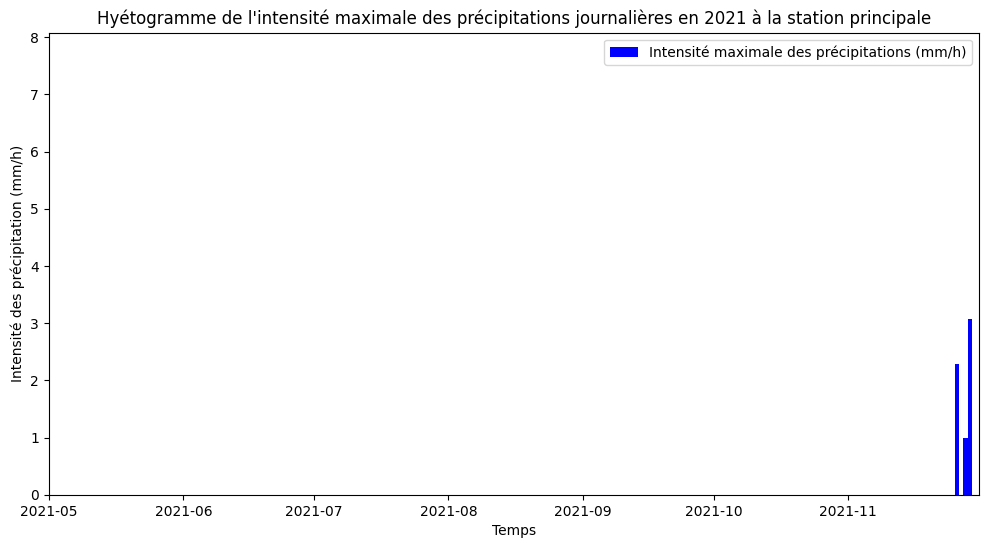

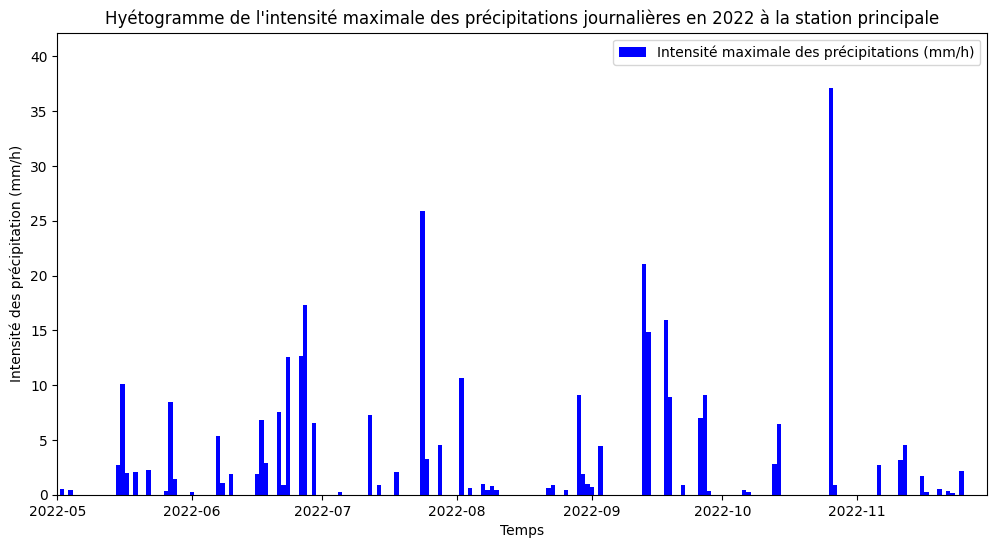

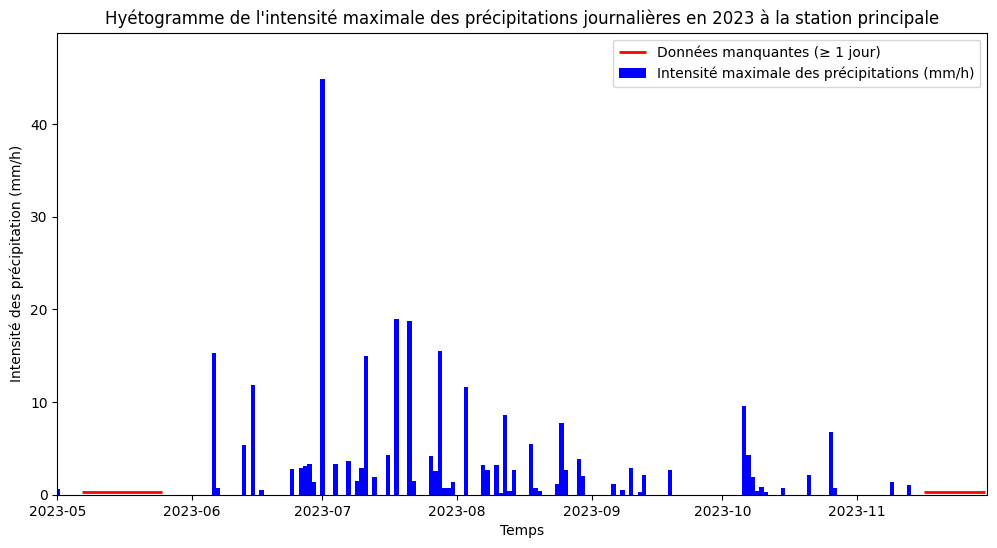

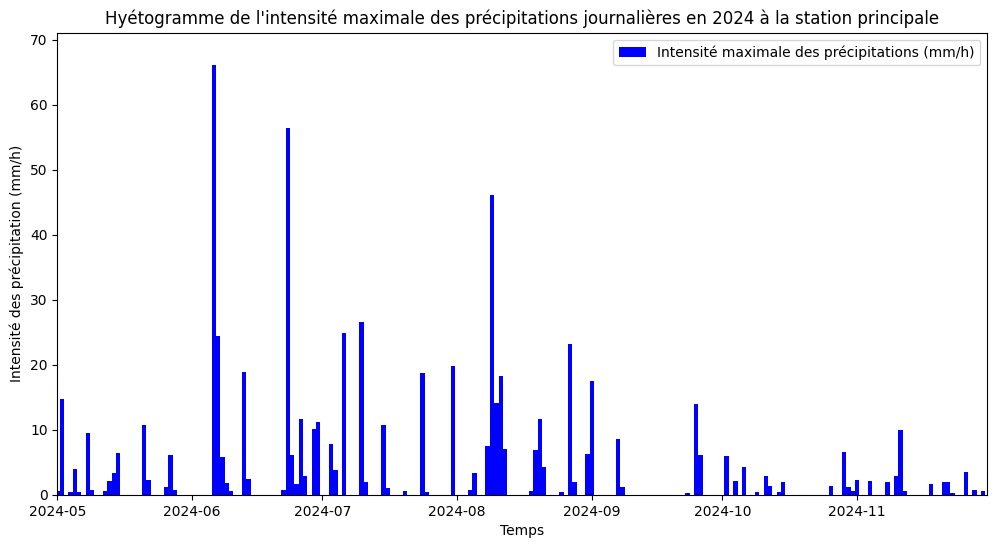

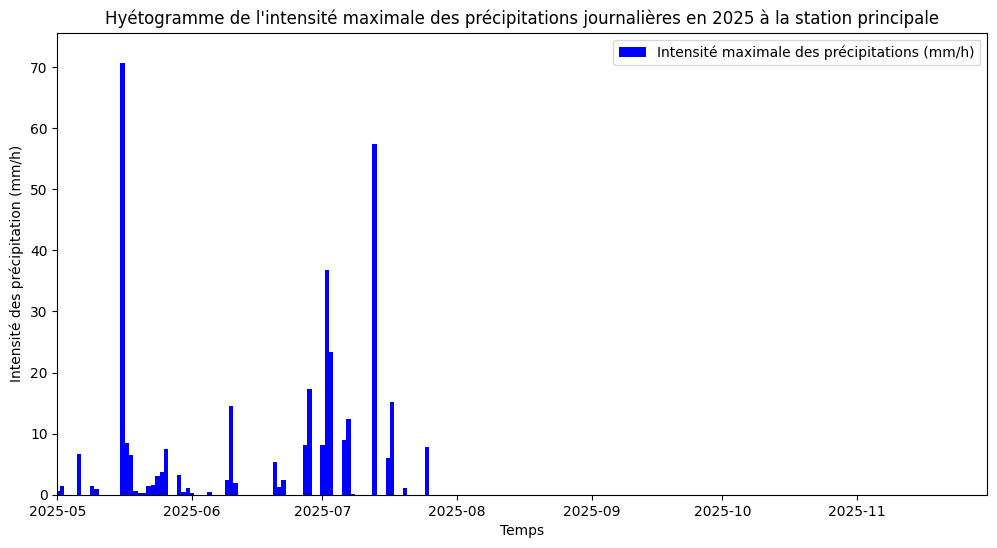

In [92]:
# HYETOGRAMME PLATE POUR CHAQUE ANNÉE
for year in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year ==year]
    df_manquantes_annee = df_manquantes.loc[df_manquantes["debut_trou"].dt.year ==year]
    hyetogramme(df_annee, df_manquantes_annee)

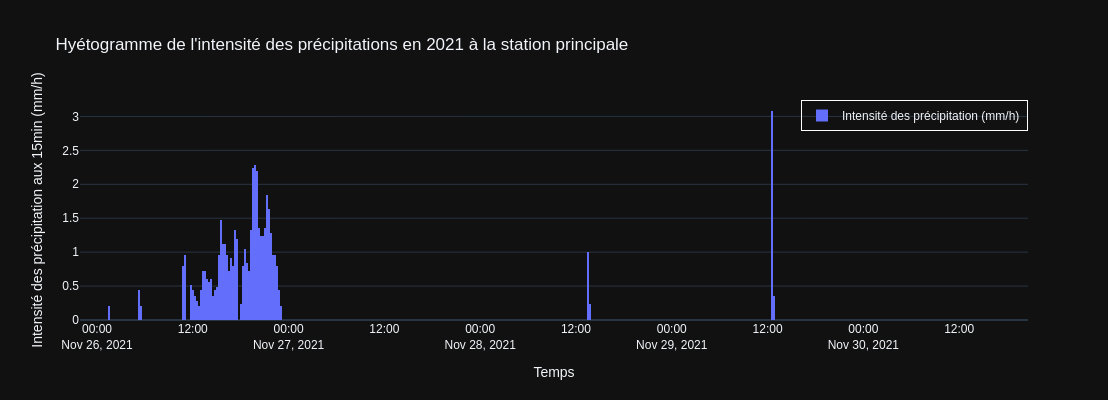

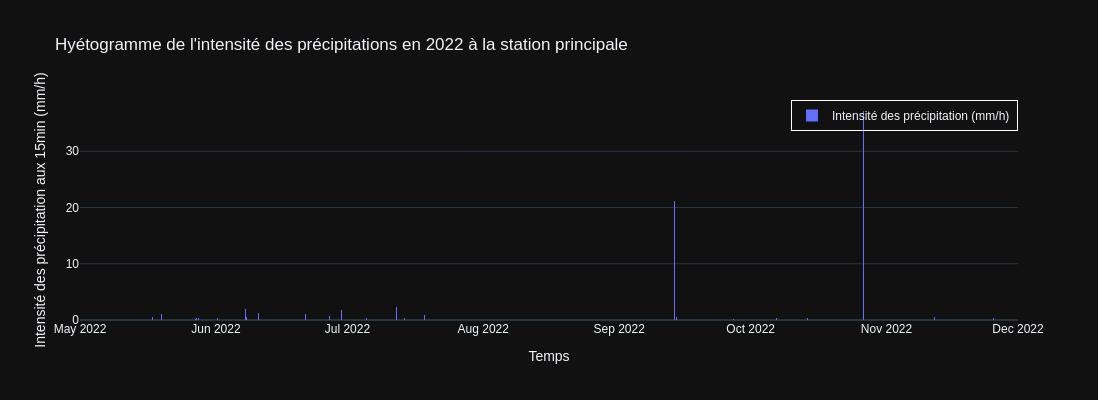

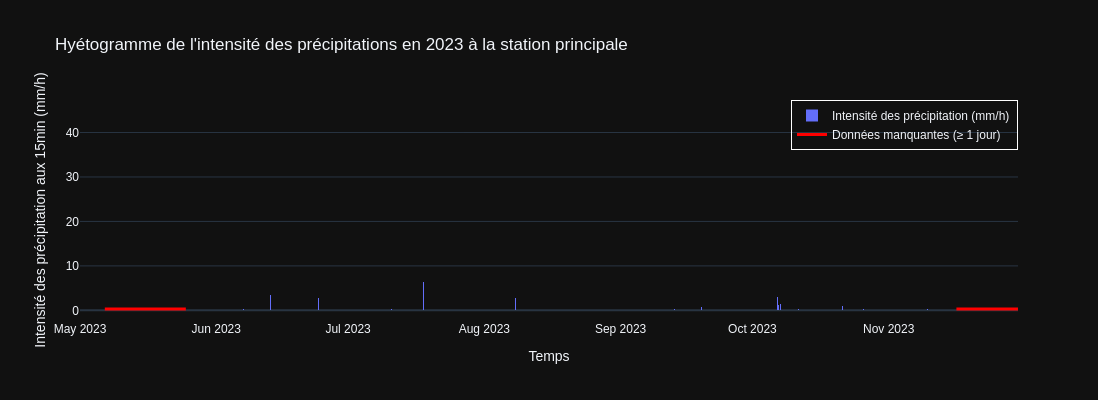

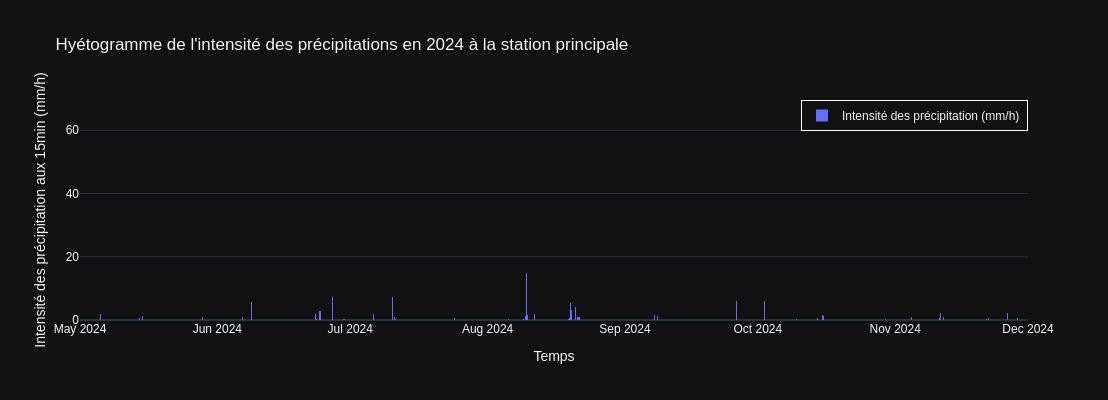

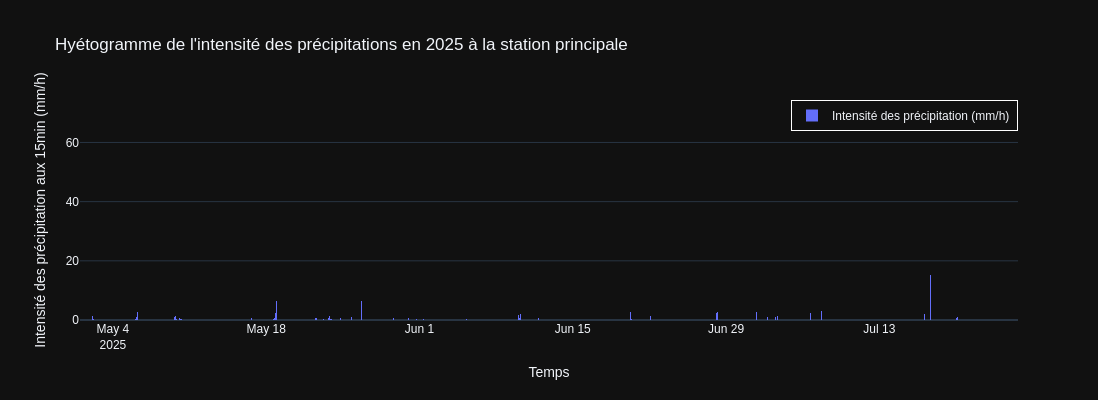

In [94]:
# HYETO INTÉRACTIF POUR CHAQUE ANNÉE
for year in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year ==year]
    df_manquantes_annee = df_manquantes.loc[df_manquantes["debut_trou"].dt.year ==year]
    hyetogramme_int(df_annee,df_manquantes_annee)

Courbe de la hauteur des pluies cumulées

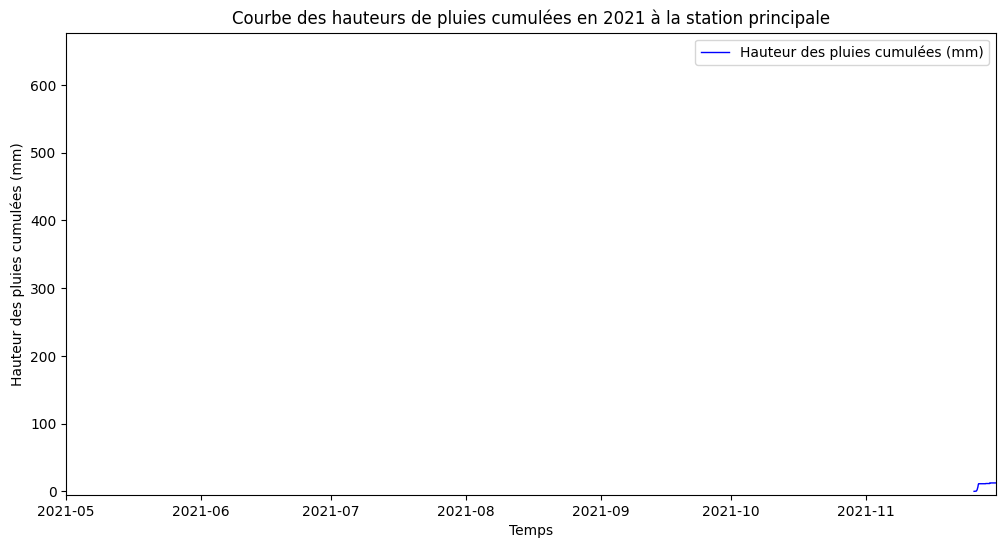

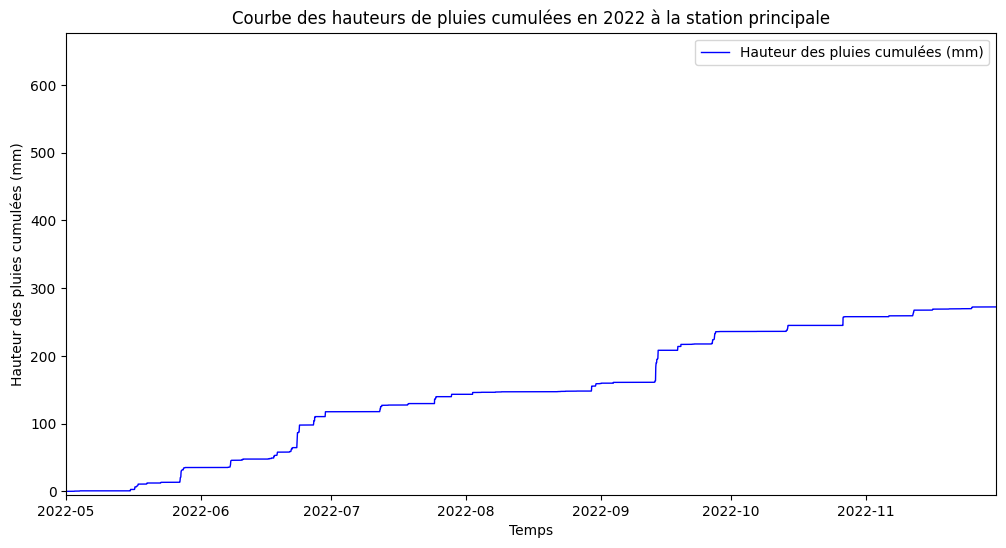

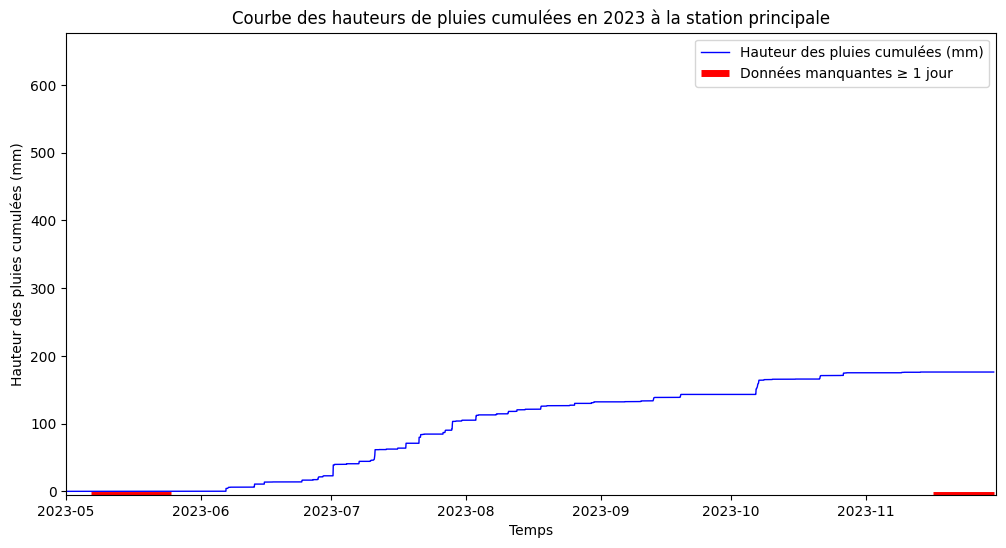

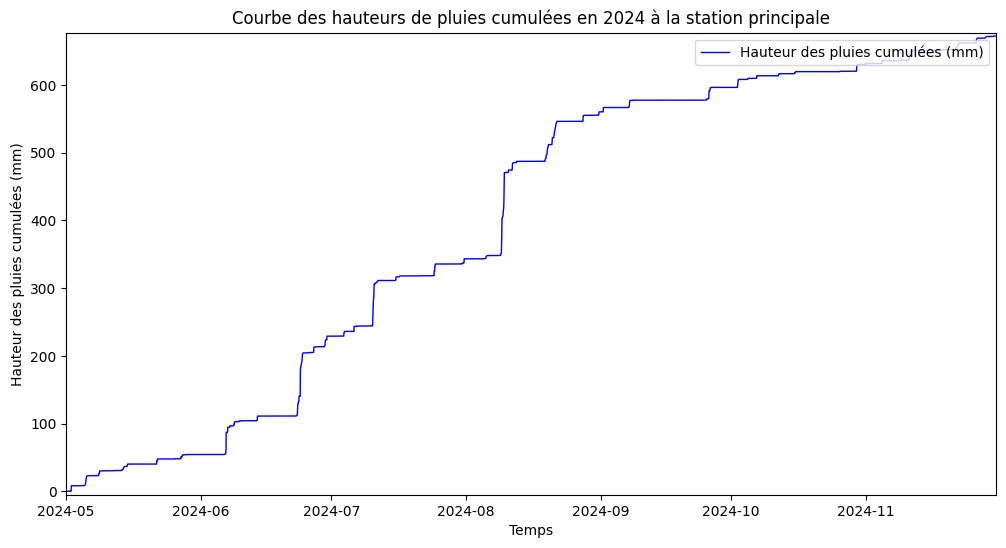

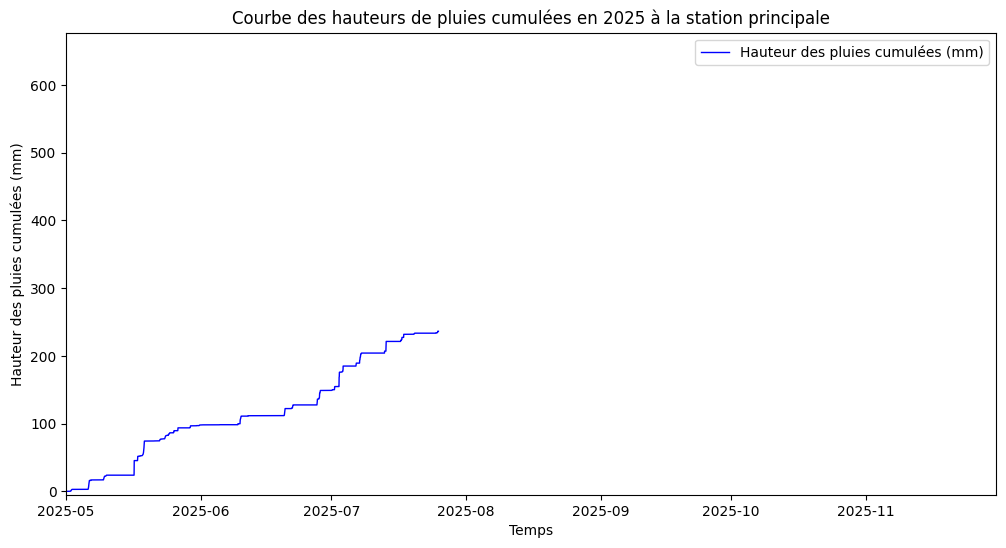

In [110]:
# PLUIES CUMULÉES PLATES POUR CHAQUE ANNÉE
for year in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year ==year]
    df_manquantes_annee = df_manquantes.loc[df_manquantes["debut_trou"].dt.year ==year]
    pluie_cumulee(df_annee, df_manquantes_annee)

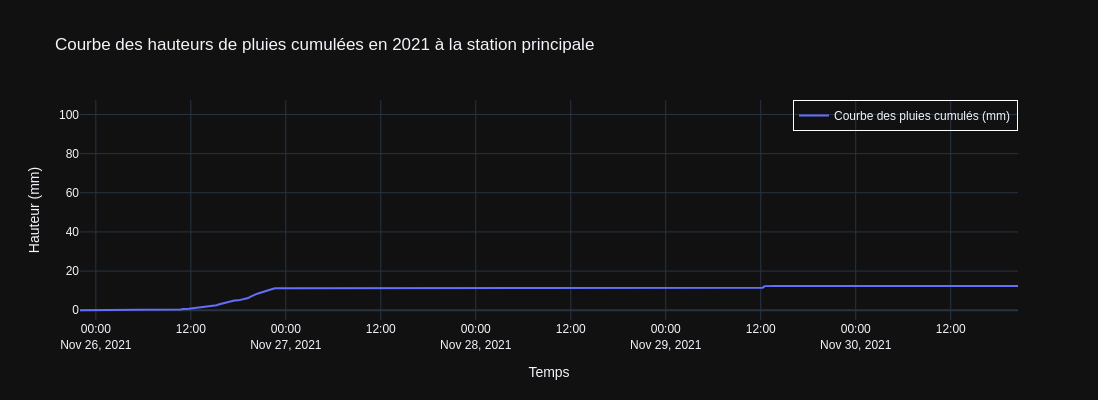

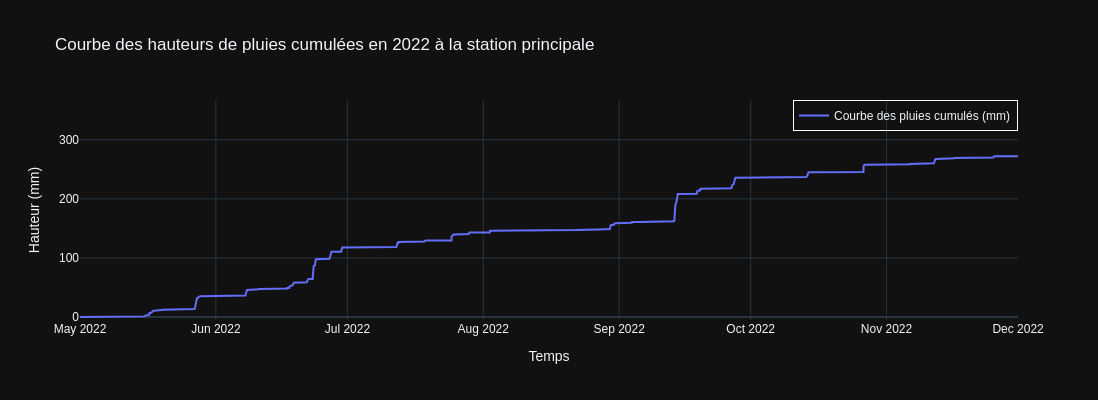

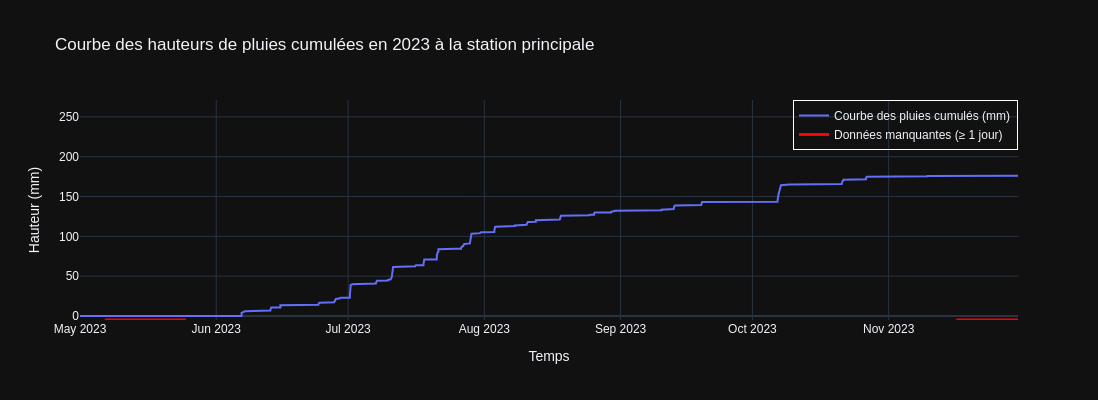

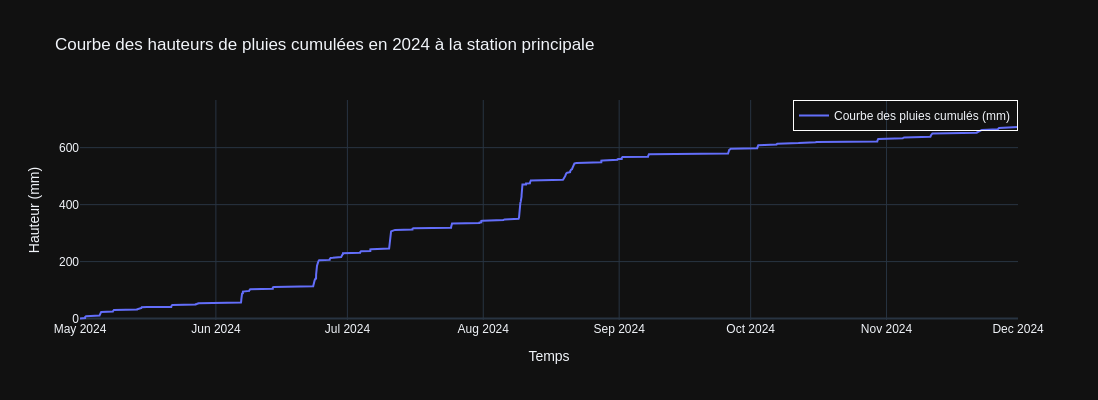

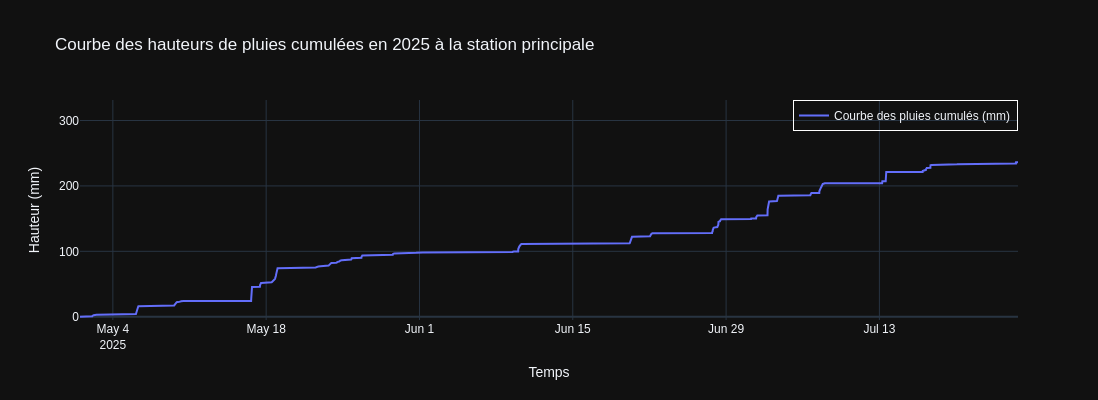

In [96]:
# PLUIES CUMULÉES INTÉRACTIVES POUR CHAQUE ANNÉE
for year in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year ==year]
    df_manquantes_annee = df_manquantes.loc[df_manquantes["debut_trou"].dt.year ==year]
    pluie_cumulee_int(df_annee,df_manquantes_annee)

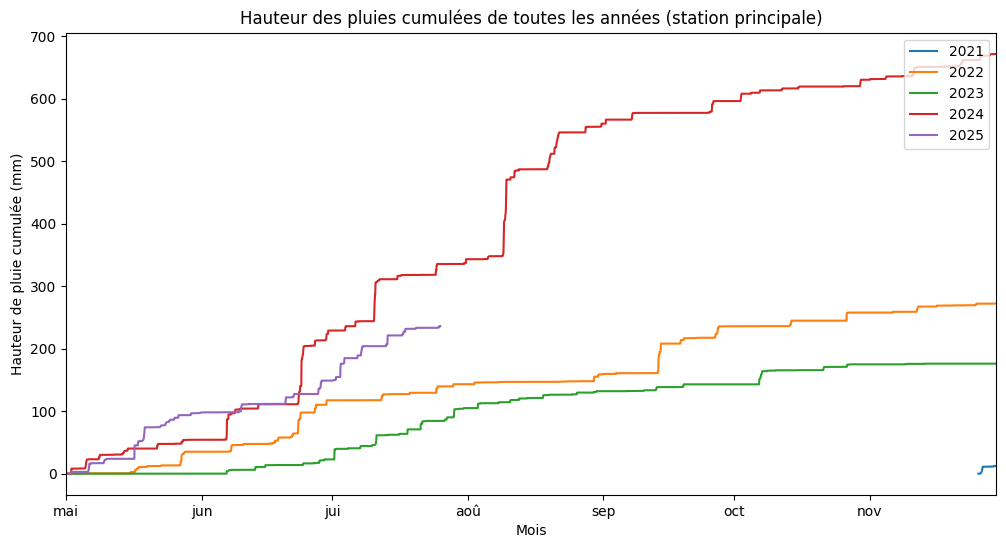

In [112]:
# PLUIES CUMULÉES TOTALES
pluie_cumulee_tot(df)

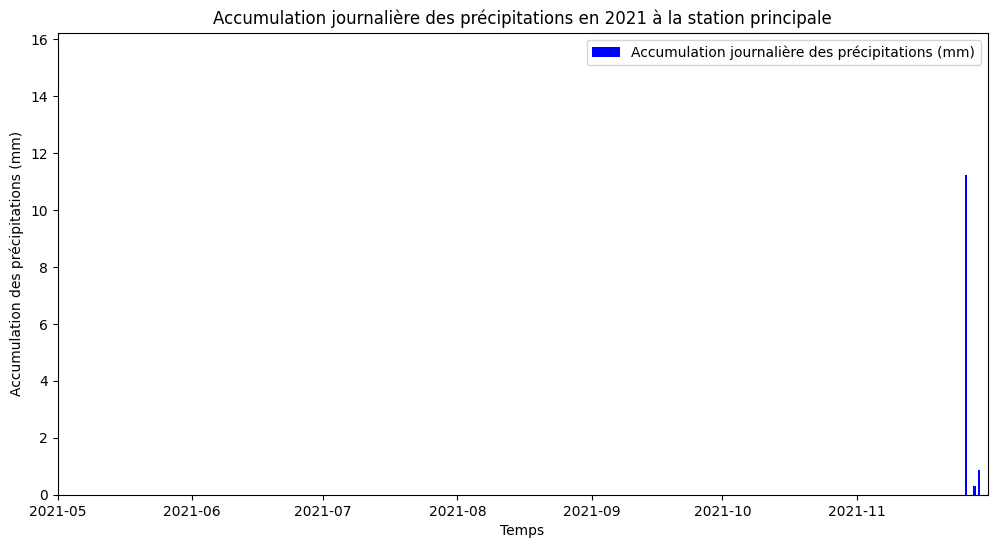

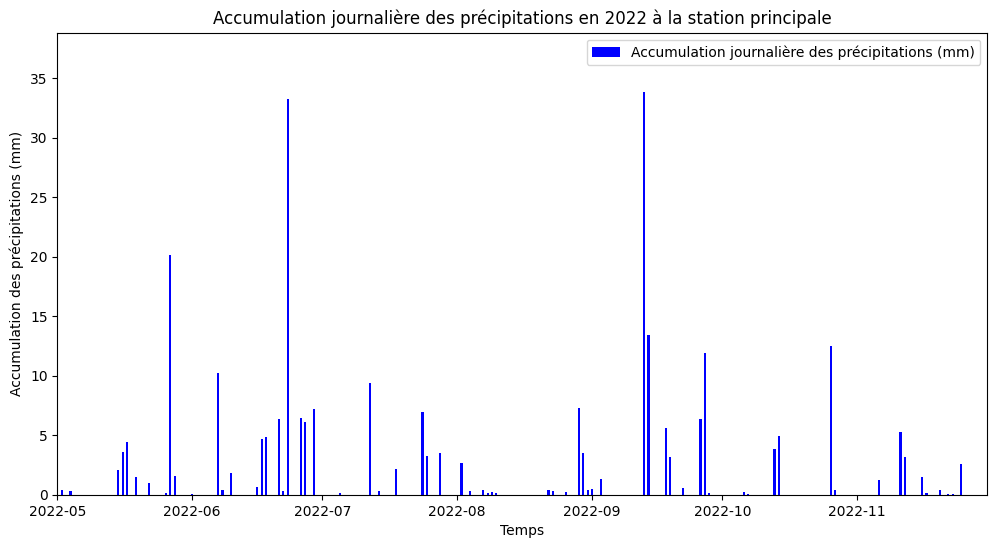

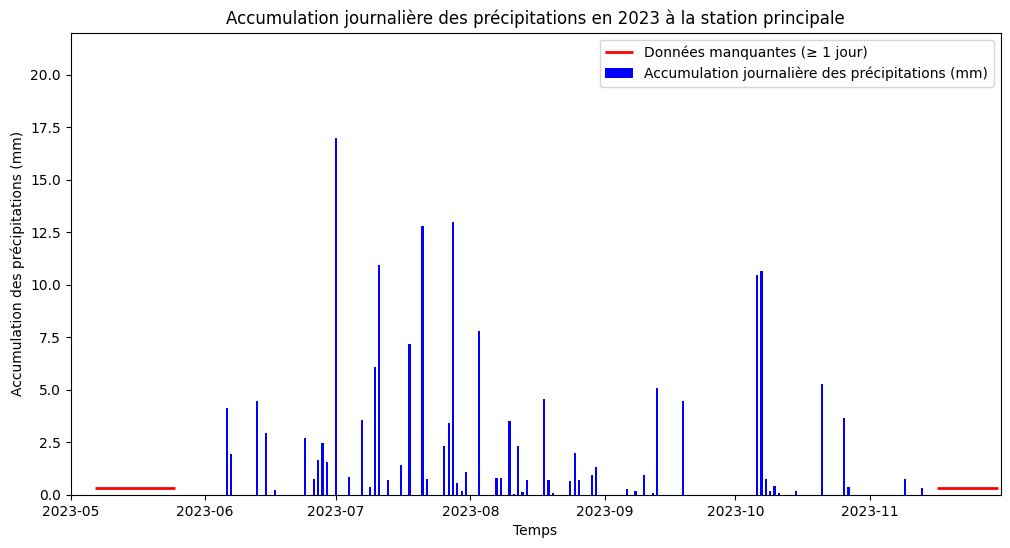

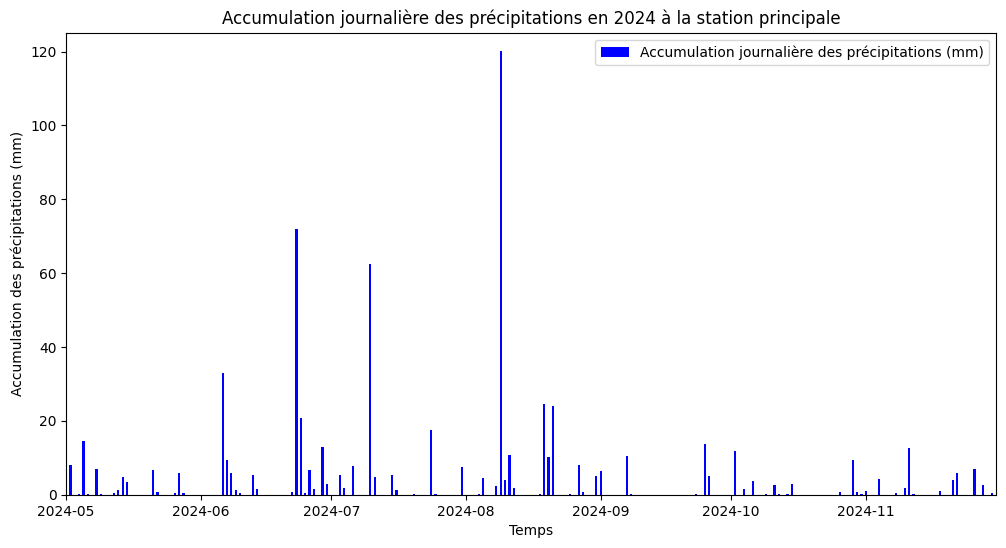

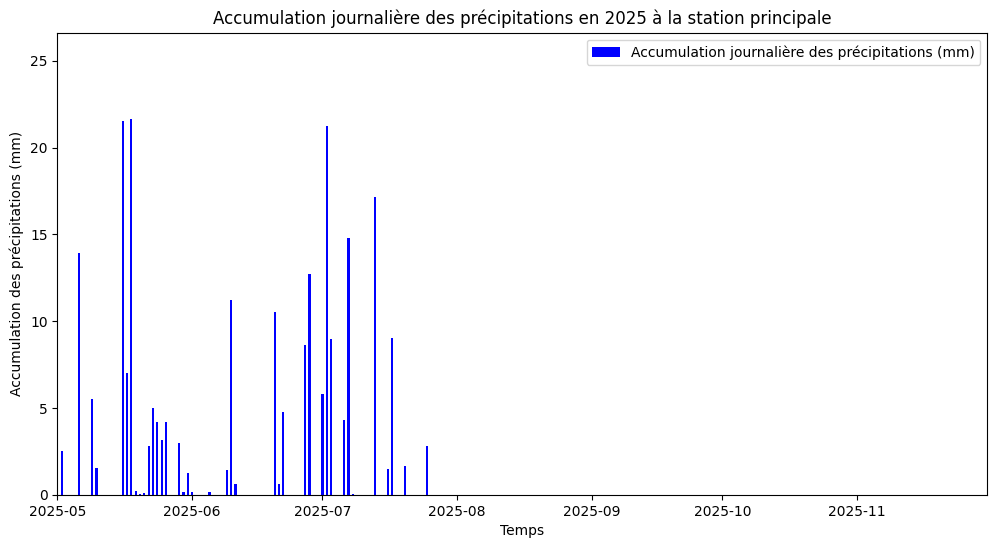

In [98]:
# ACCUMULATION JOURNALIÈRE POUR CHAQUE ANNÉE
for year in df["TIMESTAMP"].dt.year.unique():
    df_annee = df.loc[df["TIMESTAMP"].dt.year ==year]
    df_manquantes_annee = df_manquantes.loc[df_manquantes["debut_trou"].dt.year ==year]
    accum_jour(df_annee,df_manquantes_annee)

**ACCUMULATION JOURNALIÈRE DE PLUIE**

In [12]:
# Fonction qui prends en paramètre le dataframe df et renvoie le dataframe de l'accumulation journalières de pluies
# (quantité de pluie par jour) ainsi que son fichier csv
def tab_accu_jour(df):
    df = df.copy()

    # création d'un nouveau datafram (df_journalier) contenant la date (jour_timestamp)
    # et l'accumulation totale de la pluie cette journée là
    df["jour_timestamp"] = df["TIMESTAMP"].dt.date
    df_journalier = df.groupby("jour_timestamp")["Rain_mm_Tot"].sum().reset_index()
    df_journalier["jour_timestamp"] = pd.to_datetime(df_journalier["jour_timestamp"])

    # sauvegarde de la figure directement sur mon ordinateur
    df_journalier.to_csv("/home/pi/analyse_data_BVE/graph/station_principale/accum_jour/tab_accum.csv",index=False)
    return df_journalier

In [13]:
tab_accu_jour(df)

jour_timestamp  Rain_mm_Tot
0       2022-05-01         0.00
1       2022-05-02         0.42
2       2022-05-03         0.00
3       2022-05-04         0.31
4       2022-05-05         0.00
5       2022-05-06         0.00
6       2022-05-07         0.00
7       2022-05-08         0.00
8       2022-05-09         0.00
9       2022-05-10         0.00
10      2022-05-11         0.00
11      2022-05-12         0.00
12      2022-05-13         0.00
13      2022-05-14         0.00
14      2022-05-15         2.05
15      2022-05-16         3.60
16      2022-05-17         4.39
17      2022-05-18         0.00
18      2022-05-19         1.53
19      2022-05-20         0.00
20      2022-05-21         0.00
21      2022-05-22         0.99
22      2022-05-23         0.00
23      2022-05-24         0.00
24      2022-05-25         0.00
25      2022-05-26         0.12
26      2022-05-27        20.15
27      2022-05-28         1.60
28      2022-05-29         0.00
29      2022-05-30         0.00
30      2022-05-31         0.00
31      2022-06-01         0.07
32      2022-06-02         0.00
33      2022-06-03         0.00
34      2022-06-04         0.00
35      2022-06-05         0.00
36      2022-06-06         0.00
37      2022-06-07        10.24
38      2022-06-08         0.36
39      2022-06-09         0.00
40      2022-06-10         1.83
41      2022-06-11         0.00
42      2022-06-12         0.00
43      2022-06-13         0.00
44      2022-06-14         0.00
45      2022-06-15         0.00
46      2022-06-16         0.68
47      2022-06-17         4.70
48      2022-06-18         4.83
49      2022-06-19         0.00
50      2022-06-20         0.00
51      2022-06-21         6.34
52      2022-06-22         0.33
53      2022-06-23        33.30
54      2022-06-24         0.00
55      2022-06-25         0.00
56      2022-06-26         6.41
57      2022-06-27         6.10
58      2022-06-28         0.00
59      2022-06-29         7.17
60      2022-06-30         0.00
61      2022-07-01         0.00
62      2022-07-02         0.00
63      2022-07-03         0.00
64      2022-07-04         0.00
65      2022-07-05         0.16
66      2022-07-06         0.00
67      2022-07-07         0.00
68      2022-07-08         0.00
69      2022-07-09         0.00
70      2022-07-10         0.00
71      2022-07-11         0.00
72      2022-07-12         9.41
73      2022-07-13         0.00
74      2022-07-14         0.30
75      2022-07-15         0.00
76      2022-07-16         0.00
77      2022-07-17         0.00
78      2022-07-18         2.20
79      2022-07-19         0.00
80      2022-07-20         0.00
81      2022-07-21         0.00
82      2022-07-22         0.00
83      2022-07-23         0.00
84      2022-07-24         6.96
85      2022-07-25         3.24
86      2022-07-26         0.00
87      2022-07-27         0.00
88      2022-07-28         3.49
89      2022-07-29         0.00
90      2022-07-30         0.00
91      2022-07-31         0.00
92      2022-08-01         0.00
93      2022-08-02         2.66
94      2022-08-03         0.00
95      2022-08-04         0.33
96      2022-08-05         0.00
97      2022-08-06         0.00
98      2022-08-07         0.37
99      2022-08-08         0.15
100     2022-08-09         0.19
101     2022-08-10         0.16
102     2022-08-11         0.00
103     2022-08-12         0.00
104     2022-08-13         0.00
105     2022-08-14         0.00
106     2022-08-15         0.00
107     2022-08-16         0.00
108     2022-08-17         0.00
109     2022-08-18         0.00
110     2022-08-19         0.00
111     2022-08-20         0.00
112     2022-08-21         0.00
113     2022-08-22         0.43
114     2022-08-23         0.29
115     2022-08-24         0.00
116     2022-08-25         0.00
117     2022-08-26         0.21
118     2022-08-27         0.00
119     2022-08-28         0.00
120     2022-08-29         7.33
121     2022-08-30         3.48
122     2022-08-31         0.38
123     2022-09-01         0.47
124 

**ETCCDI**

Les indices ETCCDI (Expert Team on Climate Change Detection and Indices) permettent de caractériser des évènements climatiques extrêmes. Ici on calcul le RX1h (monthly maximum 1 hour precipitation), le CWD (consecutive wet day) et le CDD (consecutive dry day). Voir la liste complète sur : https://etccdi.pacificclimate.org/list_27_indices.shtml

RX1h : Intensité maximale des pluies par heure, en fonction de l'année et de la saison

In [99]:
# RX 1h pour l'été (monthly maximum 1 hour precipitation)

# La fonction RX1h prends comme paramètre le DataFrame (df) et retourne le df_RX1h contenant
# l'intensité maximale (en mm/h) selon la saison, pour chaque année
def RX1h(df):
    df = df.copy()
    
    # colonnes de df_RX1h
    df_RX1h = pd.DataFrame(columns=["ANNEE", "SAISON", "TIMESTAMP", "Rain_intensity"])
    df["annee"] = df["TIMESTAMP"].dt.year
    df["mois"] = df["TIMESTAMP"].dt.month

    for annee in df["annee"].unique():
        df_annee = df.loc[df["annee"] == annee]

        # été : mai à août
        ete = df_annee.loc[df_annee["mois"].isin([5, 6, 7, 8])]
        
        if not ete.empty:
            idx_max_ete = ete["Rain_intensity"].idxmax()
            ligne_ete = ete.loc[idx_max_ete]
            intensite_ete = ligne_ete["Rain_intensity"]
            
            # ajoute la nouvelle ligne à la fin du df_RX1h
            df_RX1h.loc[len(df_RX1h)] = [annee, "été", ligne_ete["TIMESTAMP"], intensite_ete]

        # automne : septembre à novembre
        automne = df_annee[df_annee["mois"].isin([9, 10, 11])]
        
        if not automne.empty:
            idx_max_automne = automne["Rain_intensity"].idxmax()
            ligne_automne = automne.loc[idx_max_automne]
            intensite_automne = ligne_automne["Rain_intensity"]
            
            # ajoute la nouvelle ligne à la fin du df_RX1h
            df_RX1h.loc[len(df_RX1h)] = [annee, "automne", ligne_automne["TIMESTAMP"], intensite_automne]

    return df_RX1h


# Fonction qui prends en paramètre le df_RX1h et qui retourne un graphique de barres représentant la plus grosse 
# intensité de la pluie en fonction de l'année 
def plot_RX1h(df_RX1h):
    df_RX1h = df_RX1h.copy()

    # mets tout sur l'année fictive 2000 pour créer le graphique
    df_RX1h["date_time"] = df_RX1h["TIMESTAMP"].apply(lambda dt: dt.replace(year=2000))
    
    df_RX1h["mois_jour"] = df_RX1h["TIMESTAMP"].dt.strftime("%m-%d") 
    annees_uniques = df_RX1h["TIMESTAMP"].dt.year.unique()
    nbr_annees = len(annees_uniques)

    # couleurs des années 
    colormap = colormaps.get_cmap("tab10")  
    liste_couleur = [colormap(i) for i in np.linspace(0, 1, nbr_annees)]
    couleurs = {annee: color for annee, color in zip(annees_uniques, liste_couleur)}
    df_RX1h["couleur"] = df_RX1h["TIMESTAMP"].dt.year.map(couleurs)

    # variables
    x = df_RX1h["date_time"]
    y = df_RX1h["Rain_intensity"]

    # pour avoir des pas de graduation en mois
    ticks = pd.date_range(start="2000-05-01", end="2000-11-01", freq="MS")
    noms_mois = ["Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov"]

    # création de la figure
    fig, ax = plt.subplots(figsize=(12,6))
    rects = ax.bar(x, y, width=5, color=df_RX1h["couleur"])

    # noms des mois
    ax.set_xticks(ticks)
    ax.set_xticklabels(noms_mois)
    ax.set_xlim([pd.to_datetime('2000-04-26 12:00'), pd.to_datetime('2000-12-07 12:00')])

    # couleurs des année
    for annee in annees_uniques:
        ax.bar(0, 0, color=couleurs[annee], label=str(annee))
        
    # mettres les étiquettes mois-jour au dessus des barres
    date_texte = df_RX1h["TIMESTAMP"].dt.strftime("%d-%b")
    rects = ax.patches
    mois_jour = df_RX1h["mois_jour"]

    for rect, etiquette in zip(rects, mois_jour):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height +0.5, etiquette, ha="center", va="bottom")

    # légende du reste
    plt.xlabel("Mois")
    plt.ylabel("Intensité de la pluie (mm/h)")
    ax.legend(title="Années")
    plt.title("Intensité maximale de la pluie (en mm/h)")
    

    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/ETCCDI/RX1h.png", bbox_inches="tight")
    plt.show()

Graphique de RX1h

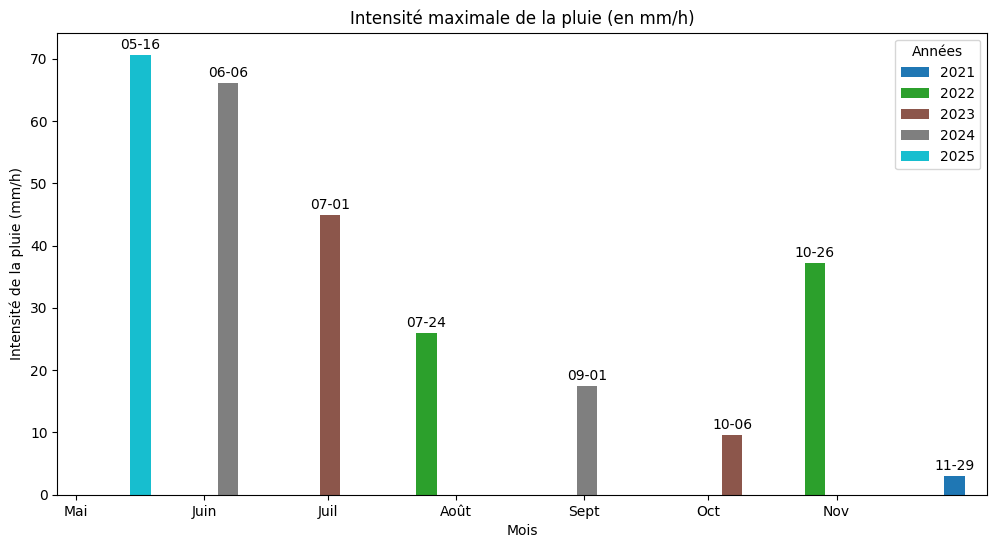

In [100]:
df_RX1h = RX1h(df)
plot_RX1h(df_RX1h)

CWD: consecutive wet day. Nombre maximal de jours consécutifs où il est tombé au moins 1mm de pluie.

In [113]:
# Fonction qui prends en paramètre le dataframe (df) et retourne le dataframe du maximum de jours
# consécutifs de pluie (df_cwd) >=1mm 
def cwd(df):
    df = df.copy()

    # modification du df pour y inclure les colonnes importantes
    df["accu_tot_jour"] = df.groupby(df["TIMESTAMP"].dt.date)['Rain_mm_Tot'].transform('sum')
    df["jour_timestamp"] = df["TIMESTAMP"].dt.date
    df["annee"] = df["TIMESTAMP"].dt.year
    df["mois"] = df["TIMESTAMP"].dt.month
    df["saison"] = ""
    df["nbr_jours"] = 0
    
    # drop ce qu'on a pas besoin
    df = df.drop(columns = ["TIMESTAMP", "Rain_mm_Tot","Rain_intensity"])
    df = df.drop_duplicates(subset=["jour_timestamp"])
    
    # on garde seulement les jours dont l'accu tot est >=1mm
    df = df.loc[df["accu_tot_jour"]>=1]
    
    # vérification des sauts temporels (pour ne pas inclure des séquences fragmentées)
    df["saut_temporel"] = df["jour_timestamp"].diff().apply(lambda x: x > pd.Timedelta(days=1))
    df.loc[1, "saut_temporel"] = True

    # TODO : voir possiblement problèmes aux bornes
    tab_nbr_jours = [0] * len(df)
    debut_seq = None

    # boucle pour calculer le nombre de jours consécutif
    for i in range(len(df)):
        # début d'une séquence
        if df["saut_temporel"].iloc[i]:
            # si ce n'est pas la première séquence:
            if debut_seq is not None:
                # remplire le tableau avec valeurs de la séquence précédente
                fin_seq = i - 1
                nbr_jours = fin_seq - debut_seq + 1
                tab_nbr_jours[debut_seq : fin_seq + 1] = [nbr_jours] * nbr_jours
        
            # sinon, début d'une nouvelle séquence
            debut_seq = i

    # ajouter le nombre de jour au df
    df["nbr_jours"] = tab_nbr_jours

    # drop colonne de saut_temporel
    df = df.drop(columns = "saut_temporel" )

    
    # création du df_cwd
    df_cwd = pd.DataFrame({
    "accu_tot_jour": pd.Series(dtype="float"),
    "jour_timestamp": pd.Series(dtype="datetime64[ns]"),
    "annee": pd.Series(dtype="int"),
    "mois": pd.Series(dtype="int"),
    "saison": pd.Series(dtype="str"),
    "nbr_jours": pd.Series(dtype="int")
    })
    
    nbr_jour_max = 0
    
    # boucle sur les années
    for annee in df["annee"].unique():
        df_annee = df.loc[df["annee"] == annee]

        # et sur les saisons
        df_ete = df_annee.loc[df_annee["mois"].isin([5, 6, 7, 8])]
        if not df_ete.empty:

            # ajouter toutes les lignes avec max nbr jour
            nbr_jour_max = df_ete["nbr_jours"].max()
            # les lignes contenant le nombre maximal (on les prends toute dans notre df_cwd)
            lignes_ete = df_ete.loc[df_ete["nbr_jours"] == nbr_jour_max].copy()

            # mettre la bonne saison
            lignes_ete["saison"] = "été"
            df_cwd = pd.concat([df_cwd, lignes_ete], ignore_index=True)

        # idem avec l'automne
        df_automne = df_annee.loc[df_annee["mois"].isin([9,10,11])]
        if not df_automne.empty:
            
            nbr_jour_max = df_automne["nbr_jours"].max()
            lignes_automne = df_automne.loc[df_automne["nbr_jours"] == nbr_jour_max].copy()
            
            lignes_automne["saison"] = "automne"
            df_cwd = pd.concat([df_cwd, lignes_automne], ignore_index=True)


    return df_cwd

# Fonction qui prends en paramètre le dataframe des jours consécutifs de pluies (df_cwd)
# et retourne le graphique de barres du maximum de jours consécutifs de pluies et de leur
# intensité en fonction de l'année, et de la saison
def plot_cwd(df_cwd):
    df_cwd = df_cwd.copy()

    # création du df_plot
    df_plot = pd.DataFrame({
    "accu_tot_jour": pd.Series(dtype="float"),
    "jour_timestamp": pd.Series(dtype="datetime64[ns]"),
    "annee": pd.Series(dtype="int"),
    "mois": pd.Series(dtype="int"),
    "saison": pd.Series(dtype="str"),
    "nbr_jours": pd.Series(dtype="int")
    })

    # boucle sur df_cwd afin de prendre la première série de jours consécutifs
    for annee in df_cwd["annee"].unique():
        df_annee = df_cwd.loc[df_cwd["annee"] == annee]

        for saison in df_annee["saison"].unique():
            df_saison = df_annee.loc[df_annee["saison"] == saison]

            if not df_saison.empty:
                n = df_saison.iloc[0]["nbr_jours"]
                df_plot = pd.concat([df_plot, df_saison.iloc[0:n]], ignore_index=True)

    # conversion en datetime
    df_plot["jour_timestamp"] = pd.to_datetime(df_plot["jour_timestamp"])
    df_plot["jour_timestamp"] = df_plot["jour_timestamp"].dt.strftime("%m-%d")
    df_plot["annee"] = df_plot["annee"].astype(int)

    # variables pour le graphique
    saisons_couleurs = {"été": "navy", "automne": "skyblue"}
    couleurs = []
    width = 0.5 
    x = []
    y = []
    x_pos_actu = 0
    y_max = df_plot["accu_tot_jour"].max() + 15

    # positionnement et nom de la graduation sur l'axe des x (années)
    grad_pos = []
    grad_annee = []

    # légende pour indiquer le mois et le jour de la barre
    mois_jour = []

    # boucle sur toutes les années
    for annee in df_plot["annee"].unique():
        df_annee = df_plot.loc[df_plot["annee"] == annee]
        
        # nombre de jours avec pluie pour chaque année
        nbr_jours = len(df_annee) 

        # calcul le tableau de la position des barre (x) en aditionnant la position actuelle, au tableau du 
        # nombre de jour fois la taille (plus un espace de 0.1 entre chaque barres)
        x_pos_annee = x_pos_actu + np.arange(nbr_jours) * (width + 0.1)

        # autres variables
        y_val_annee = df_annee["accu_tot_jour"].values
        saisons = df_annee["saison"].values
        mois_jour_annee = df_annee["jour_timestamp"].values

        # assigner la bonne couleur selon la saison
        couleurs_annee = []
        for saison in df_annee["saison"]:
            if saison == "été":
                couleurs_annee.append("navy")
            elif saison == "automne":
                couleurs_annee.append("skyblue")

        # rajouter les valeurs de l'année dans les variables totales
        x.extend(x_pos_annee)
        y.extend(y_val_annee)
        couleurs.extend(couleurs_annee)
        mois_jour.extend(mois_jour_annee)

        # position des graduations de l'axe des x
        grad_pos.append(np.mean(x_pos_annee)) 
        grad_annee.append(str(annee))

        # calcul de la position actuelle en x, plus un espace de 2 entre les années
        x_pos_actu = x_pos_annee[-1] + width + 2  

    # création de la figure
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(x, y, width=width, color=couleurs)

    # ajout des étiquettes mois-jour
    for rect, label in zip(bars, mois_jour):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 2,
            label,
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=90)

    # titres et légendes
    ax.set_xticks(grad_pos)
    ax.set_xticklabels(grad_annee)
    ax.set_xlabel("Années")
    ax.set_ylabel("Accumulation totale par journée (mm)")
    ax.set_ylim(0, y_max)
    ax.set_title("Consecutive Wet Day par année")

    # couleurs des saisons 
    legend_saison = []
    for saison,color in saisons_couleurs.items():
        patch = Patch(facecolor=color, label=saison)
        legend_saison.append(patch)

    
    ax.legend(handles=legend_saison)
    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/ETCCDI/cwd.png", bbox_inches="tight")
    plt.show()


Graphique de cwd

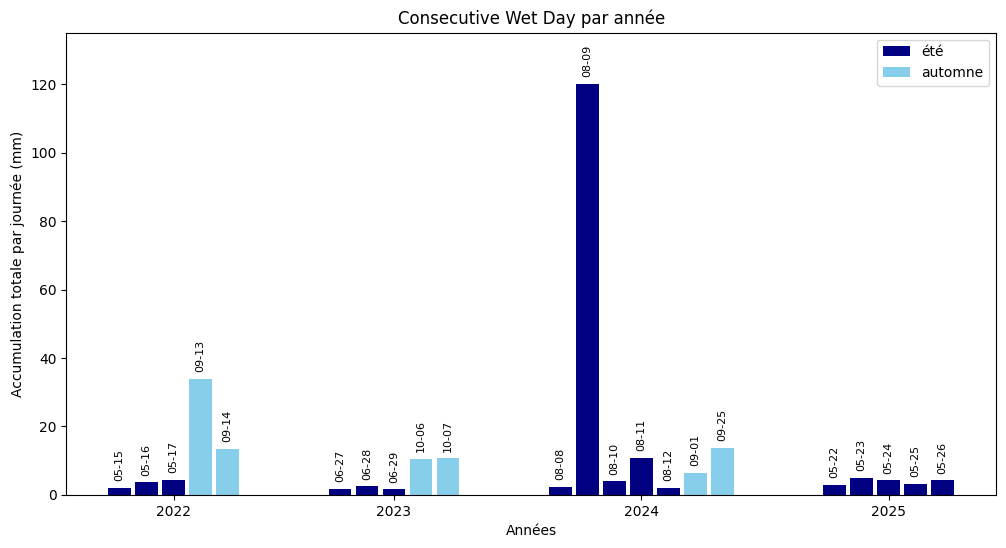

In [114]:
df_cwd = cwd(df)
plot_cwd(df_cwd)

CDD: consecutive dry day, jour sans pluies consécutif maximal (0mm)

In [115]:
# Fonction qui prends en paramètre le dataframe (df) et retourne le dataframe du maximum de jours
# consécutifs sans pluie (df_cdd)
def cdd(df):
    df = df.copy()

    # modification du df pour y inclure les colonnes importantes
    df["accu_tot_jour"] = df.groupby(df["TIMESTAMP"].dt.date)['Rain_mm_Tot'].transform('sum')
    df["jour_timestamp"] = df["TIMESTAMP"].dt.date
    df["annee"] = df["TIMESTAMP"].dt.year
    df["mois"] = df["TIMESTAMP"].dt.month
    df["saison"] = ""
    df["nbr_jours"] = 0
    
    # drop ce qu'on a pas besoin
    df = df.drop(columns = ["TIMESTAMP", "Rain_mm_Tot","Rain_intensity"])
    df = df.drop_duplicates(subset=["jour_timestamp"])

    # on garde seulement les jours dont l'accu tot est de 0
    df = df.loc[df["accu_tot_jour"]==0]
    
    # vérification des sauts temporels (pour ne pas inclure des séquences fragmentées)
    df["saut_temporel"] = df["jour_timestamp"].diff().apply(lambda x: x > pd.Timedelta(days=1))
    df.loc[1, "saut_temporel"] = True

    # TODO : voir possiblement problèmes aux bornes
    nbr_jours = [0] * len(df)
    debut_seq = None

    # boucle pour calculer le nombre de jours consécutif
    for i in range(len(df)):
        # début d'une séquence
        if df["saut_temporel"].iloc[i]:
            # si ce n'est pas la première séquence:
            if debut_seq is not None:
                # remplir le tableau avec valeurs de la séquence précédente
                fin_seq = i - 1
                longueur = fin_seq - debut_seq + 1
                nbr_jours[debut_seq : fin_seq + 1] = [longueur] * longueur
        
            # sinon, début d'une nouvelle séquence
            debut_seq = i

    # ajouter le nombre de jour au df
    df["nbr_jours"] = nbr_jours

    # drop colonne de saut_temporel
    df = df.drop(columns = "saut_temporel" )

    
    # création du df_cdd
    df_cdd = pd.DataFrame({
    "accu_tot_jour": pd.Series(dtype="float"),
    "jour_timestamp": pd.Series(dtype="datetime64[ns]"),
    "annee": pd.Series(dtype="int"),
    "mois": pd.Series(dtype="int"),
    "saison": pd.Series(dtype="str"),
    "nbr_jours": pd.Series(dtype="int")
    })
    
    nbr_jour_max = 0
    
    # boucle sur les années
    for annee in df["annee"].unique():
        df_annee = df.loc[df["annee"] == annee]

        # et sur les saisons
        df_ete = df_annee.loc[df_annee["mois"].isin([5, 6, 7, 8])]
        if not df_ete.empty:

            # ajouter toutes les lignes avec max nbr jour
            nbr_jour_max = df_ete["nbr_jours"].max()
            # les lignes contenant le nombre maximal (on les prends toute dans notre df_cdd)
            lignes_ete = df_ete.loc[df_ete["nbr_jours"] == nbr_jour_max].copy()

            # mettre la bonne saison
            lignes_ete["saison"] = "été"
            df_cdd = pd.concat([df_cdd, lignes_ete], ignore_index=True)

        # idem avec l'automne
        df_automne = df_annee.loc[df_annee["mois"].isin([9,10,11])]
        if not df_automne.empty:
            
            nbr_jour_max = df_automne["nbr_jours"].max()
            lignes_automne = df_automne.loc[df_automne["nbr_jours"] == nbr_jour_max].copy()

            lignes_automne["saison"] = "automne"
            df_cdd = pd.concat([df_cdd, lignes_automne], ignore_index=True)


    return df_cdd

# Fonction qui prends en paramètre le dataframe des jours consécutifs sans pluies (df_cdd)
# et retourne le graphique de barres du maximum de jours consécutifs sans pluies en 
# fonction de l'année, et de la saison
def plot_cdd(df_cdd):
    df_cdd = df_cdd.copy()

    # création du df_plot
    df_plot = pd.DataFrame({
        "jour_timestamp": pd.Series(dtype="datetime64[ns]"),
        "annee": pd.Series(dtype="int"),
        "mois": pd.Series(dtype="int"),
        "saison": pd.Series(dtype="str"),
        "nbr_jours": pd.Series(dtype="int")
    })

    # prendre le premier jour de chaque série consécutive
    for annee in df_cdd["annee"].unique():
        df_annee = df_cdd.loc[df_cdd["annee"] == annee]
        
        for saison in df_annee["saison"].unique():
            df_saison = df_annee.loc[df_annee["saison"] == saison]
            
            if not df_saison.empty:
                premier_jour = df_saison.iloc[[0]]
                df_plot = pd.concat([df_plot, premier_jour], ignore_index=True)

    # conversion en datetime
    df_plot["jour_timestamp"] = pd.to_datetime(df_plot["jour_timestamp"])
    df_plot["jour_timestamp"] = df_plot["jour_timestamp"].dt.strftime("%m-%d")
    df_plot["annee"] = df_plot["annee"].astype(int)

    # variables pour le graphique
    saisons_couleurs = {"été": "red", "automne": "orange"}
    couleurs = []
    width = 0.5
    x = []
    y = []
    x_pos_actu = 0
    y_max = df_plot["nbr_jours"].max() + 2
    
    # positionnement et nom de la graduation sur l'axe des x (années)
    grad_pos = []
    grad_annee = []

    # légende pour indiquer le mois et le jour de la barre
    mois_jour = []

    # boucle sur toutes les année
    for annee in df_plot["annee"].unique():
        df_annee = df_plot.loc[df_plot["annee"] == annee]
        
        # nombre de jours avec pluie pour chaque année
        nbr_jours = len(df_annee)

        # calcul le tableau de la position des barre (x) en aditionnant la position actuelle, au tableau du 
        # nombre de jour fois la taille (plus un espace de 0.1 entre chaque barres)
        x_pos_annee = x_pos_actu + np.arange(nbr_jours) * (width + 0.1)


        # assigner la bonne couleur selon la saison
        for saison in df_annee["saison"]:
            couleurs.append(saisons_couleurs.get(saison, "grey"))

        # graduations pour chaque année
        grad_pos.append(np.mean(x_pos_annee))
        grad_annee.append(str(annee))

        # rajouter les valeurs de l'année dans les variables totales
        x.extend(x_pos_annee)
        y.extend(df_annee["nbr_jours"].values)
        mois_jour.extend(df_annee["jour_timestamp"].values)

        # calcul de la position actuelle en x, plus un espace de 2 entre les années
        x_pos_actu = x_pos_annee[-1] + width + 2

    # création de la figure
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(x, y, width=width, color=couleurs)

    # ajout des étiquettes mois-jour
    for rect, label in zip(bars, mois_jour):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.5,
            label,
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=90
        )

    # titres et légendes
    ax.set_xticks(grad_pos)
    ax.set_xticklabels(grad_annee)
    ax.set_xlabel("Années")
    ax.set_ylabel("Nombre maximal de jours consécutifs sans pluie (CDD)")
    ax.set_ylim(0, y_max)
    ax.set_yticks(range(0, df_cdd["nbr_jours"].max() + 1, 2))
    ax.set_title("CDD par année")

    # couleurs des saisons
    legend_saison = []
    for saison,color in saisons_couleurs.items():
        patch = Patch(facecolor=color, label=saison)
        legend_saison.append(patch)

    ax.legend(handles=legend_saison)
    plt.savefig(f"/home/pi/analyse_data_BVE/graph/station_principale/ETCCDI/cdd.png", bbox_inches="tight")
    plt.show()


Graphique de cdd

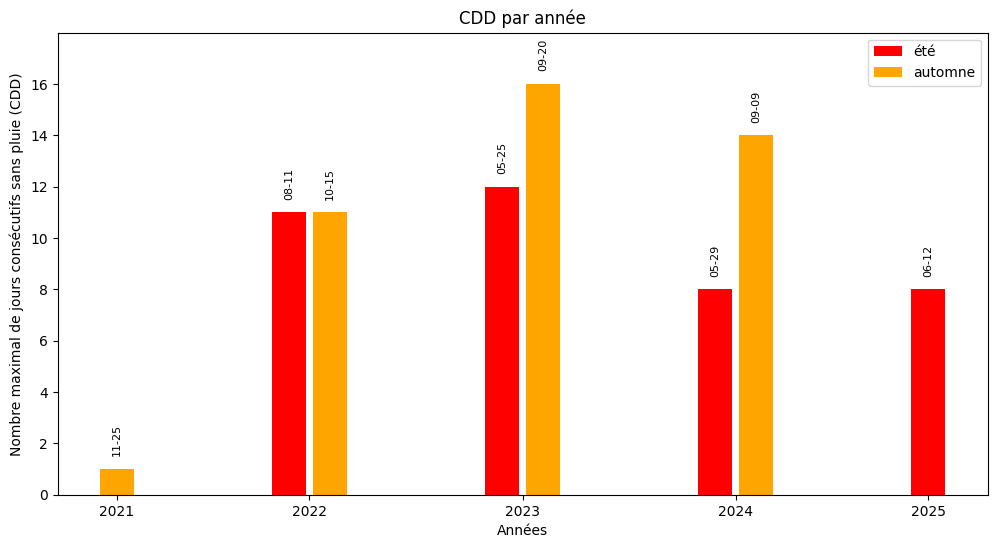

In [116]:
df_cdd = cdd(df)
plot_cdd(df_cdd)